In [27]:
# Preamble  here, add paths and import relevant modules
import os
import sys
base_path = '/'.join(os.getcwd().split('/')[:-1])
sys.path.append('/'.join(os.getcwd().split('/')[:-1]))
import util
reload(util)
import numpy as np 
import sklearn
from sklearn import datasets
from scipy.sparse.linalg import eigsh
from numpy.random import permutation
from scipy import ndimage
from scipy import misc
% matplotlib inline
import matplotlib.pyplot as plt

# Tutorial 3 --  Nystrom Extension

`Nystrom Extension` is a way of computing *approximately* the eigenvectors of a graph Laplacian. It is a sampling strategy to bypass the $O(N^2)$ complexity in constructing the full Laplalacian Matrix. Since it's a sampling strategy, we need the graph to be well-connected enough so that the samples correctly reflect the geometry of the original graph

We load the test image `Two Cows` and use Nystrom Extension to compute its kernels. Since we are clustering, it's no surprise that the names of our datasets start with a number. 

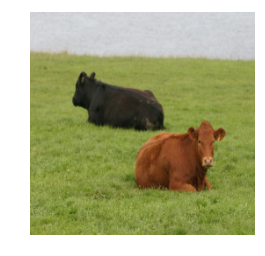

In [28]:
# load the two cows image
img = np.float32(misc.imresize(misc.imread(base_path+'/data/Images/twocows.png'),(256,256)))/255.
#initialization
import graph_cluster as gc
reload(gc)
clf = gc.LaplacianClustering()
clf.load_data(raw_data = util.imageblocks(img, width = 2)) #patch size = 2*width + 1
plt.imshow(img)
plt.rcParams['figure.figsize'] = (5, 5)
plt.axis('off')
plt.show()

To use Nystrom, simply switch the `Eig_solver` property to 'nystrom'. Currently the affinity only supports 'rbf' kernel, with either cosine or euclidean distance metric. 

In [29]:
clf.build_graph(Neig = 100,Eig_solver = 'nystrom',gamma = 1, num_nystrom = 100)

Below is a visualization of the eigenvectors we have just computed. 

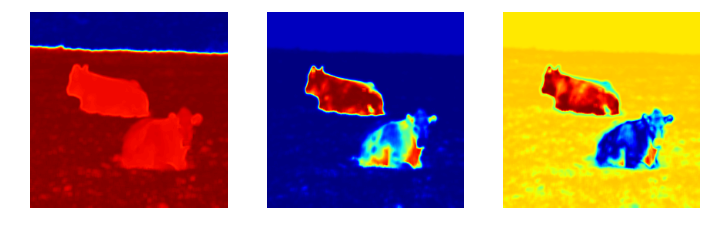

In [31]:
v = clf.graph.laplacian_matrix_['V']
e = clf.graph.laplacian_matrix_['E']
plt.figure(2)
for i in range(1,4):
    plt.subplot(1,3,i)
    plt.imshow(v[:,i].reshape(img.shape[0],img.shape[1]))
    plt.axis('off')
plt.rcParams['figure.figsize'] = (10, 5)
plt.tight_layout()  
plt.show()    

This image roughly has four regions, and the eigenvectors clearly reflect those regions. But what about images that have less clear delineations? We'll next try the `lena` image. 

In [32]:
# load the lena image
img = np.float32(misc.imresize(misc.imread(base_path+'/data/Images/lena.png'),(256,256)))/255.
clf.load_data(util.imageblocks(img, width = 2)) #patch size = 2*width + 1
clf.build_graph(Neig = 100,Eig_solver = 'nystrom',gamma = 1, num_nystrom = 100)

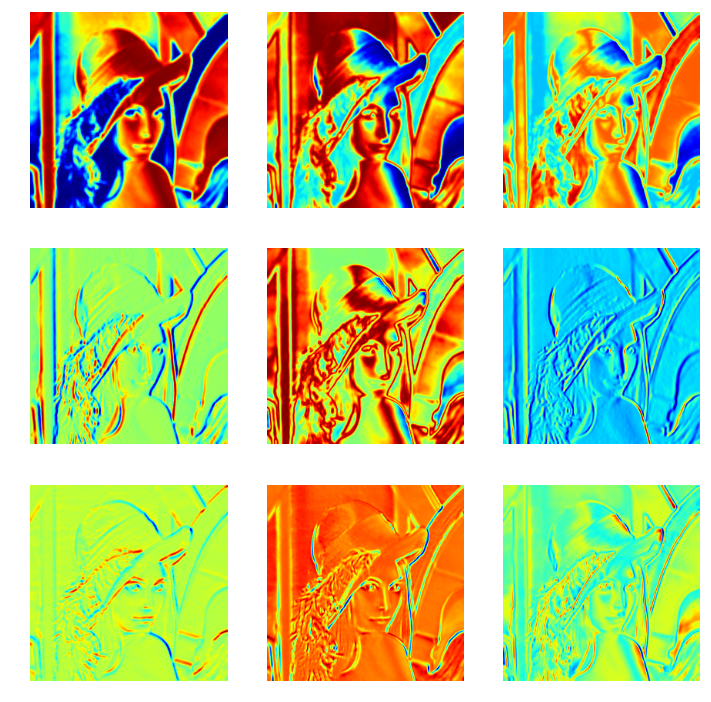

In [34]:
v = clf.graph.laplacian_matrix_['V']
e1 = clf.graph.laplacian_matrix_['E']
plt.figure(2)
for i in range(3):
    for j in range(3):
        plt.subplot(3,3,i*3+j+1)
        plt.imshow(v[:,i*3+j+1].reshape(img.shape[0],img.shape[1]))
        plt.axis('off')
plt.rcParams['figure.figsize'] = (10, 10)
plt.tight_layout()  
plt.show()   

We see that the eigenvalues are much more complicated, and capture some of the variation along the edges. Let's experiment with adjusting the kernel width $\gamma$.

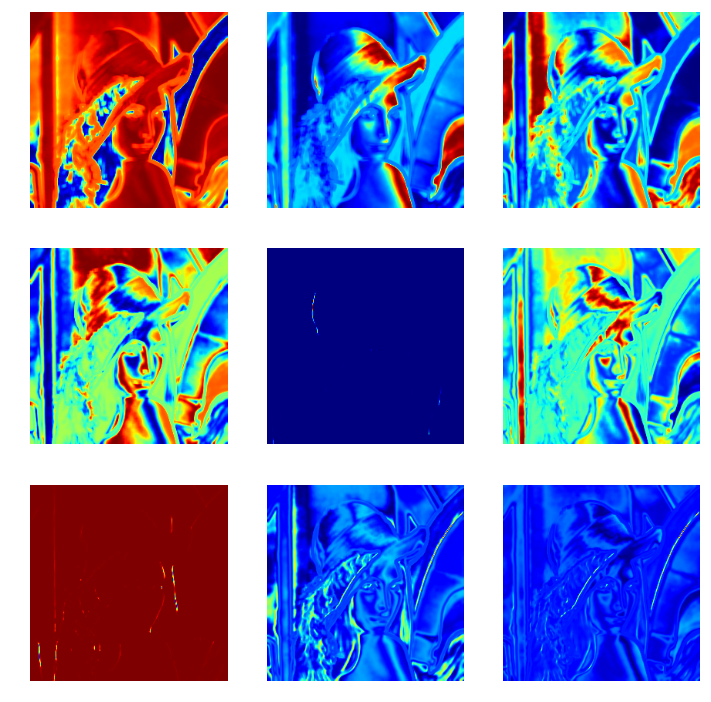

In [37]:
clf.set_graph_params(gamma = 0.1)
v = clf.graph.laplacian_matrix_['V']
e2 = clf.graph.laplacian_matrix_['E']
plt.figure(2)
for i in range(3):
    for j in range(3):
        plt.subplot(3,3,i*3+j+1)
        plt.imshow(v[:,i*3+j+1].reshape(img.shape[0],img.shape[1]))
        plt.axis('off')
plt.rcParams['figure.figsize'] = (10, 10)
plt.tight_layout()  
plt.show()   

The eigenvectors seem much more blurry than the previous version. Let's compare the eivenvalue curves

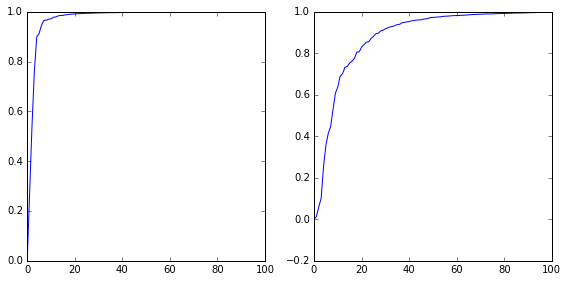

In [39]:
plt.figure(3)
a = plt.subplot(1,2,1)
plt.plot(e1)
a.set_ylim([0, 1])
plt.subplot(1,2,2)
plt.plot(e2)
plt.rcParams['figure.figsize'] = (8, 4)
plt.tight_layout()  
plt.show() 

We conclude this section by doing some semi-supervised and unsupervised clustering on the cow images. We first try MBO with fidelity. 

u_init not provided. Generating random initial condition.


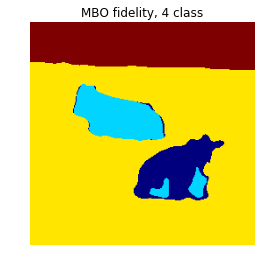

In [112]:
# load the two cows image
img = np.float32(misc.imresize(misc.imread(base_path+'/data/Images/twocows.png'),(256,256)))/255.
#initialization
import graph_cluster as gc
from util import ImageHandler
clf = gc.LaplacianClustering(scheme_type = 'MBO_fidelity', eta = 2, dt = .2, n_class = 4)
h = ImageHandler(img)
clf.load_data(raw_data = util.imageblocks(img, width = 4)) #patch size = 2*width + 1
clf.build_graph(Neig = 20,Eig_solver = 'nystrom',gamma = 2, num_nystrom = 100)
# generate for patches of fidelity of width 10
fid = h.generate_fidelity_from_block(60,100,10,10,value = 1) # black cow
fid =np.concatenate((fid,h.generate_fidelity_from_block(150,150,10,10,value = 0)),axis = 0) # red cow
fid =np.concatenate((fid,h.generate_fidelity_from_block(50,170,10,10,value = 2)),axis = 0) # grass
fid =np.concatenate((fid,h.generate_fidelity_from_block(0,0,10,10,value = 3)),axis = 0) # sky
clf.set_parameters(fid = fid)
# predict
clf.fit_predict()
# plot results
plt.imshow(h.to_2d(clf.labels_))
plt.axis('off')
plt.title('MBO fidelity, 4 class')
plt.show()

Next, we try spectral clustering.  You can play around with `Neig`, and `gamma`, but it seems to get stuck in local minima very often

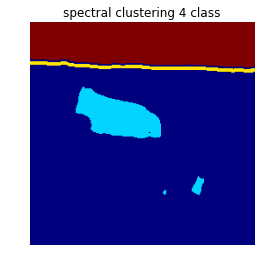

In [119]:
clf.set_parameters(scheme_type = 'spectral_clustering')
clf.build_graph(Neig = 10,Eig_solver = 'nystrom',gamma = 2, num_nystrom = 100)
clf.fit_predict()
plt.imshow(h.to_2d(clf.labels_))
plt.axis('off')
plt.title('spectral clustering 4 class')
plt.show()

Next, We try out `MBO_modularity`. Somehow it separates the cows perfectly! Even better than the semi-supervised version. 

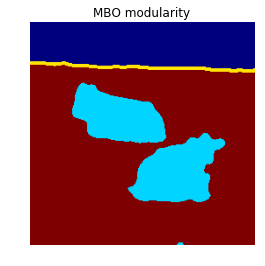

In [127]:
clf.set_parameters(scheme_type = 'MBO_modularity',gamma = 3, dt = .4, n_class = 4)
clf.fit_predict()
plt.imshow(h.to_2d(clf.labels_))
plt.axis('off')
plt.title('MBO modularity')
plt.show()